Datasets

In [349]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [351]:
# Dataset Preparation for Machine Learning

# 1. Load Datasets
# Load the training dataset from the specified file path.
# This dataset will be split into training and testing subsets.
df = pd.read_csv('C:/Users/wredn/Downloads/fe_last/train_data_fe.csv')

# Load the validation dataset from the specified file path.
# This dataset will be used exclusively for validation.
df_valid = pd.read_csv('C:/Users/wredn/Downloads/fe_last/test_data_fe.csv')

# 2. Target Variable
# The target variable (dependent variable) is specified by its column name.
# This is the variable the model will be trained to predict.
target_col = 'Radiation_mean'

# 3. Split Main Dataset into Training and Testing Subsets
# The main dataset (df) is split into two parts:
# - Training set: 80% of the data is randomly sampled.
# - Testing set: The remaining 20% of the data.
train_df = df.sample(frac=0.8, random_state=42)  # Randomly sample 80% for training
test_df = df.drop(train_df.index)  # The remaining 20% for testing

# 4. Separate Features and Target for Training and Testing Sets
# For both training and testing subsets:
# - Features (X): All columns except the target column.
# - Target (y): The target column specified by 'target_col'.
x_train = train_df.drop(columns=[target_col])  # Features for training
y_train = train_df[target_col]  # Target for training

x_test = test_df.drop(columns=[target_col])  # Features for testing
y_test = test_df[target_col]  # Target for testing

# 6. Prepare Validation Set
# The validation dataset (df_valid) is used as a separate set for evaluation.
# Similar to the training and testing sets, features and target are separated.
x_valid = df_valid.drop(columns=[target_col])  # Features for validation
y_valid = df_valid[target_col]  # Target for validation

# Outputs:
# - x_train, y_train: Features and target for training the model.
# - x_test, y_test: Features and target for testing the model.
# - x_valid, y_valid: Features and target for validating the model.

# Notes:
# - Ensure the file paths to the datasets are correct.
# - The target column ('Radiation_mean') must exist in all datasets.
# - This setup ensures reproducibility of the training/testing split using random_state.


### Feature selection

Here we construct the Maximum Relevance Minimum Redundancy algorithm for regression problem. 

In [345]:
# Feature Selection using mRMR for Regression

# 1. calculate_relevance_pearson
# This function calculates the relevance of each feature in the dataset
# to the target variable using the Pearson correlation coefficient.
# Parameters:
# - df: Input DataFrame containing features and target variable.
# - target: Column name of the target variable.
# Returns:
# - A NumPy array of absolute Pearson correlation values for each feature.
def calculate_relevance_pearson(df, target):
    y = df[target]  # Target variable
    X = df.drop(columns=[target])  # Features
    relevance = []

    for feature in X.columns:
        correlation, _ = pearsonr(X[feature], y)  # Pearson correlation
        relevance.append(abs(correlation))  # Store absolute value of correlation
    return np.array(relevance)

# 2. calculate_redundancy
# This function calculates the redundancy between two features using the
# Pearson correlation coefficient.
# Parameters:
# - feature1: A feature (Pandas Series).
# - feature2: Another feature (Pandas Series).
# Returns:
# - Absolute value of the Pearson correlation coefficient between the two features.
def calculate_redundancy(feature1, feature2):
    return abs(pearsonr(feature1, feature2)[0])  # Absolute Pearson correlation

# 3. mrmr_feature_selection_regression
# This function implements the Minimum Redundancy Maximum Relevance (mRMR)
# feature selection algorithm for regression tasks.
# Parameters:
# - df: Input DataFrame containing features and the target variable.
# - target: Column name of the target variable.
# - K: Number of features to select.
# - relevance_func: A function to calculate relevance scores (e.g., calculate_relevance_pearson).
# Returns:
# - A list of selected features.
def mrmr_feature_selection_regression(df, target, K, relevance_func):
    # Step 1: Calculate relevance scores for all features
    features = df.columns.drop(target)  # All features except the target
    relevance_scores = relevance_func(df, target)  # Relevance scores
    feature_relevance = dict(zip(features, relevance_scores))  # Map features to scores

    # Step 2: Initialize selection process
    selected_features = []  # List of selected features
    remaining_features = list(features)  # List of remaining features

    # Select the first feature with the highest relevance
    first_feature = max(feature_relevance, key=feature_relevance.get)
    selected_features.append(first_feature)
    remaining_features.remove(first_feature)

    # Step 3: Iteratively select features
    while len(selected_features) < K:
        scores = {}
        for feature in remaining_features:
            # Calculate redundancy with already selected features
            redundancy_sum = np.sum([
                calculate_redundancy(df[feature], df[selected])
                for selected in selected_features
            ])
            # Calculate adjusted score: relevance - normalized redundancy
            relevance = feature_relevance[feature]
            redundancy = redundancy_sum / (len(selected_features) ** 2)
            scores[feature] = relevance - redundancy

        # Select the next feature with the highest adjusted score
        next_feature = max(scores, key=scores.get)
        selected_features.append(next_feature)
        remaining_features.remove(next_feature)

    # Return the list of selected features
    return selected_features


In [347]:
# Feature Selection Execution using mRMR for Regression

# Parameters:
# - train: DataFrame containing the training data, including features and the target variable.
# - 'Radiation_mean': The name of the target variable column in the dataset.
# - K: Number of features to select. 
#       In this case, K is set to the total number of features minus one (target column is excluded).
# - calculate_relevance_pearson: A function to calculate the relevance of features to the target
#       using the Pearson correlation coefficient.

# Step-by-step explanation:
# 1. Determine the number of features to select (K):
#    - `train.shape[1]` gives the total number of columns in the training dataset.
#    - Subtracting 1 accounts for the target column (`'Radiation_mean'`), leaving only feature columns.
K = (train.shape[1]) - 1

# 2. Perform mRMR feature selection:
#    - The `mrmr_feature_selection_regression` function selects K features that are most relevant
#      to the target (`'Radiation_mean'`) while minimizing redundancy between the features.
#    - `calculate_relevance_pearson` is used to compute relevance scores for features.

# Execute feature selection
selected_features = mrmr_feature_selection_regression(train, 'Radiation_mean', K, calculate_relevance_pearson)

# Output:
# - `selected_features`: A list of the selected feature names.
#    These features are the most relevant to the target variable while maintaining minimal redundancy.

# Notes:
# - Ensure that `train` contains the target column ('Radiation_mean') and all features as numeric values.
# - The selection process can take time for large datasets with many features due to pairwise redundancy calculations.


### Modeling

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
=== TOP 10 MODELS BY RMSE ===
          Model  Top_n_features        R2        RMSE
45  

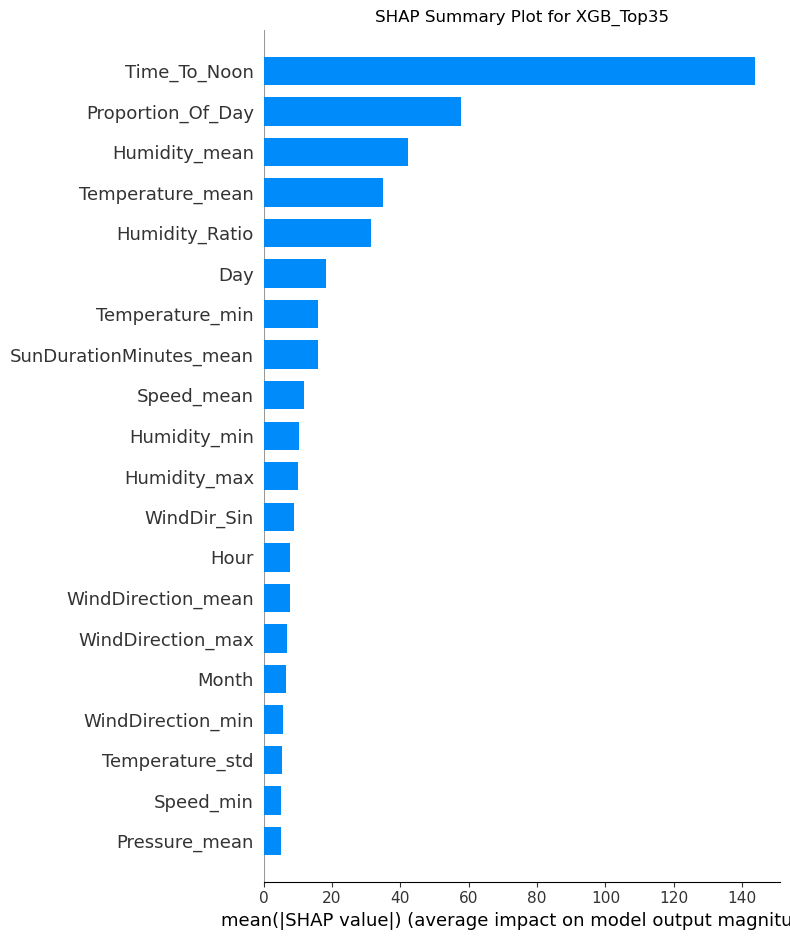

Validation Results for XGB_Top35: R²: 0.8742, RMSE: 111.1057

Computing SHAP for model: XGB_Top36


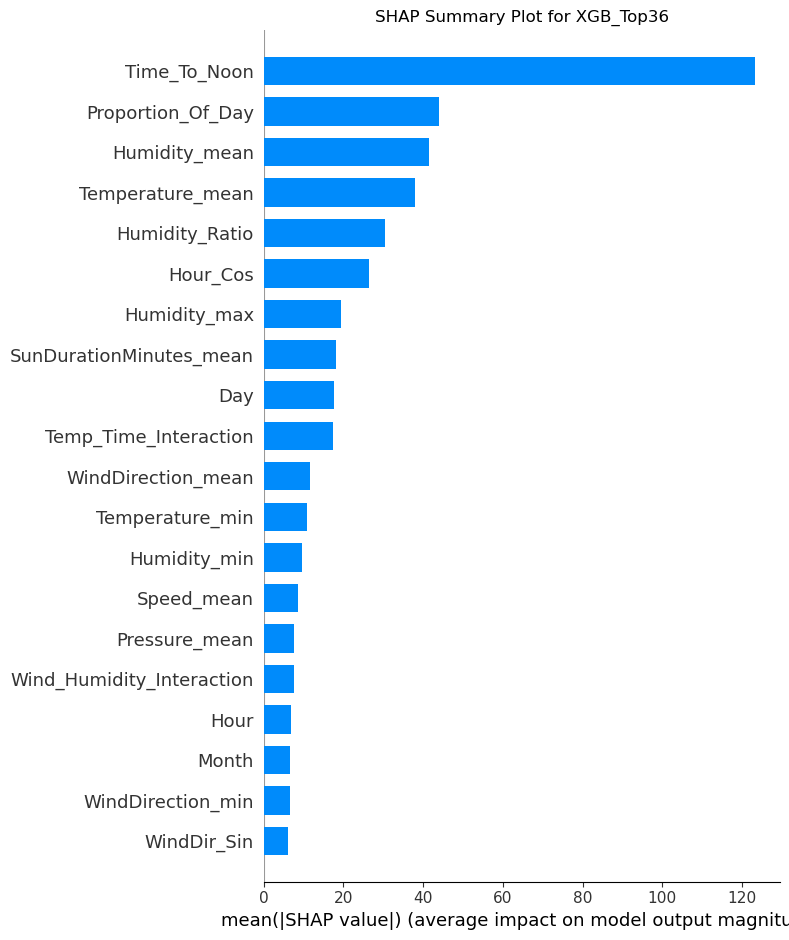

Validation Results for XGB_Top36: R²: 0.8730, RMSE: 111.6393

Computing SHAP for model: XGB_Top30


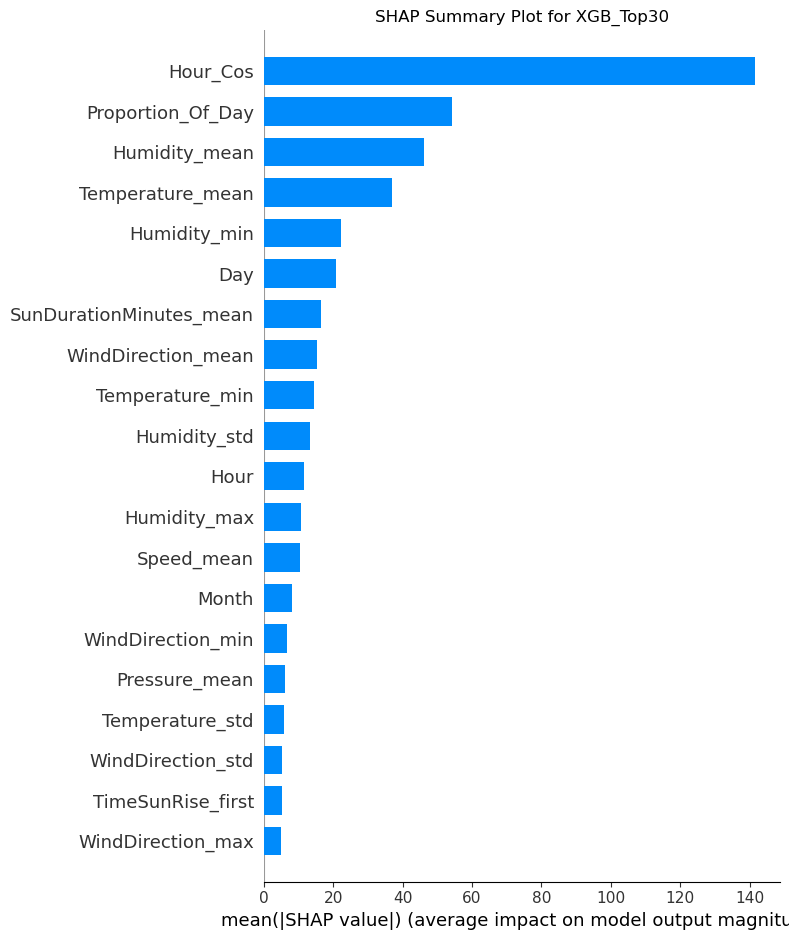

Validation Results for XGB_Top30: R²: 0.8784, RMSE: 109.2382

Computing SHAP for model: XGB_Top15


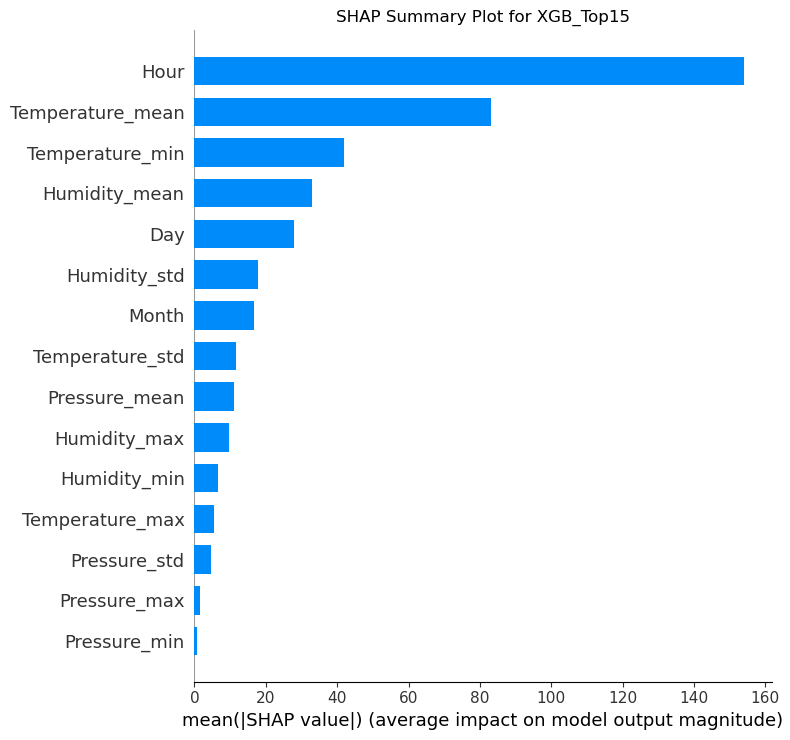

Validation Results for XGB_Top15: R²: 0.8690, RMSE: 113.3926

Computing SHAP for model: XGB_Top25


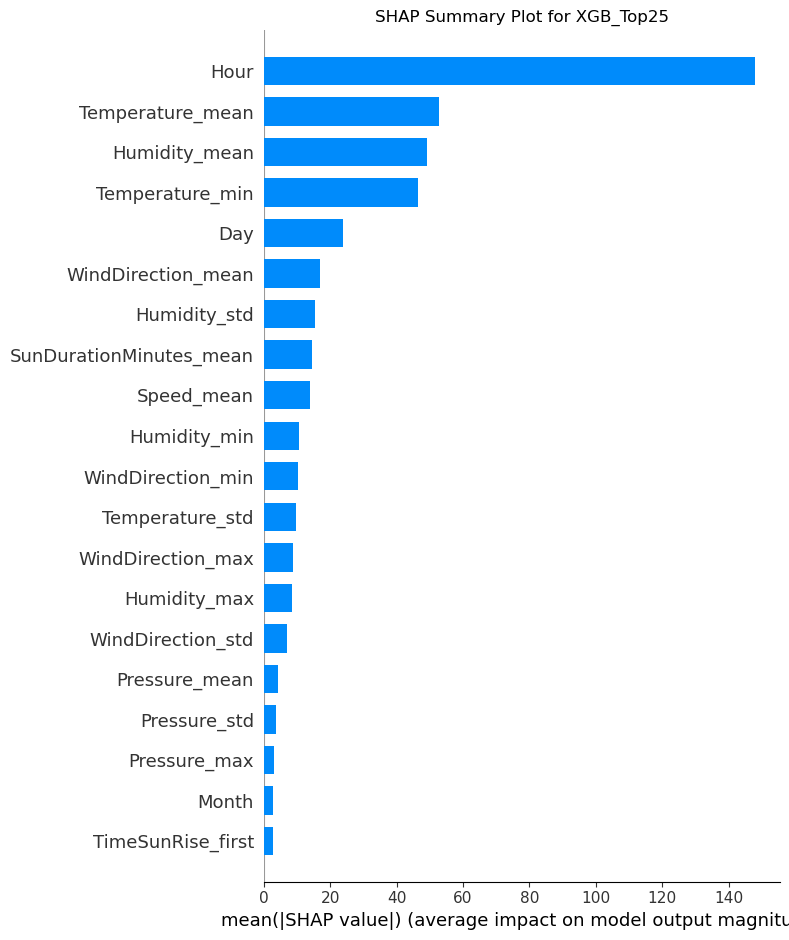

Validation Results for XGB_Top25: R²: 0.8633, RMSE: 115.8176

Computing SHAP for model: XGB_Top20


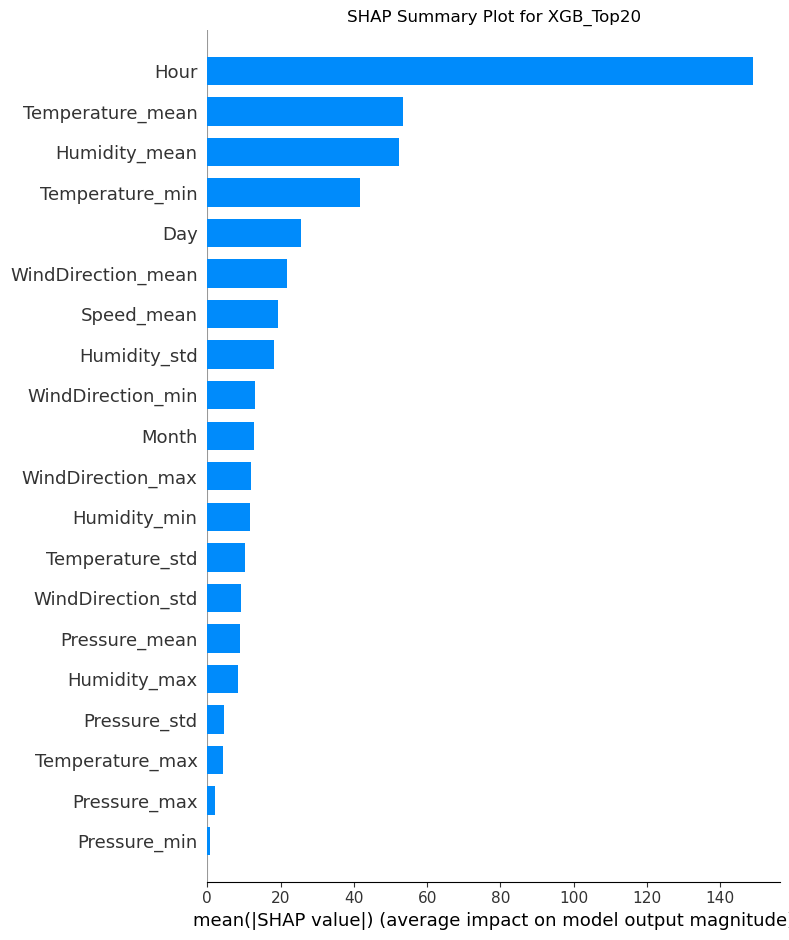

Validation Results for XGB_Top20: R²: 0.8540, RMSE: 119.6900

Computing SHAP for model: XGB_Top5


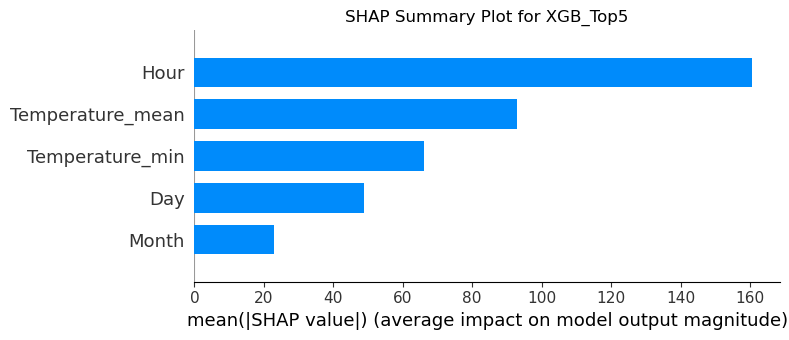

Validation Results for XGB_Top5: R²: 0.8605, RMSE: 117.0201

Computing SHAP for model: XGB_Top10


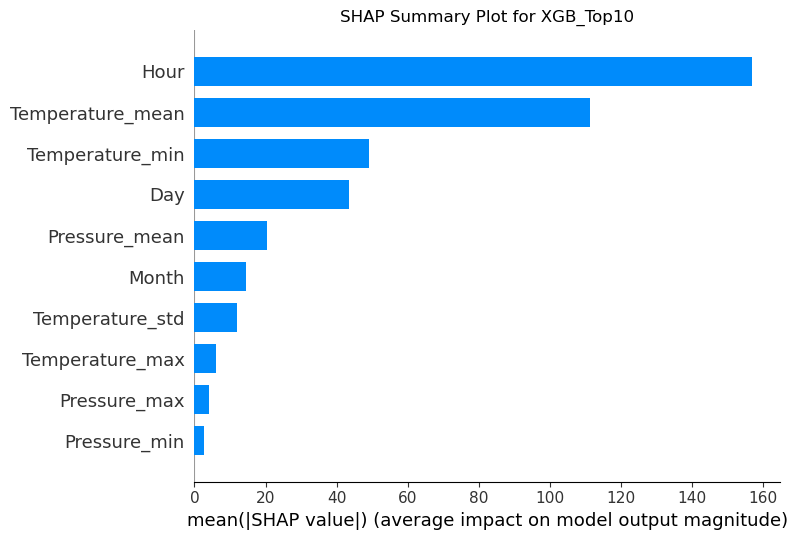

Validation Results for XGB_Top10: R²: 0.8498, RMSE: 121.4286

Computing SHAP for model: Ridge_Top30


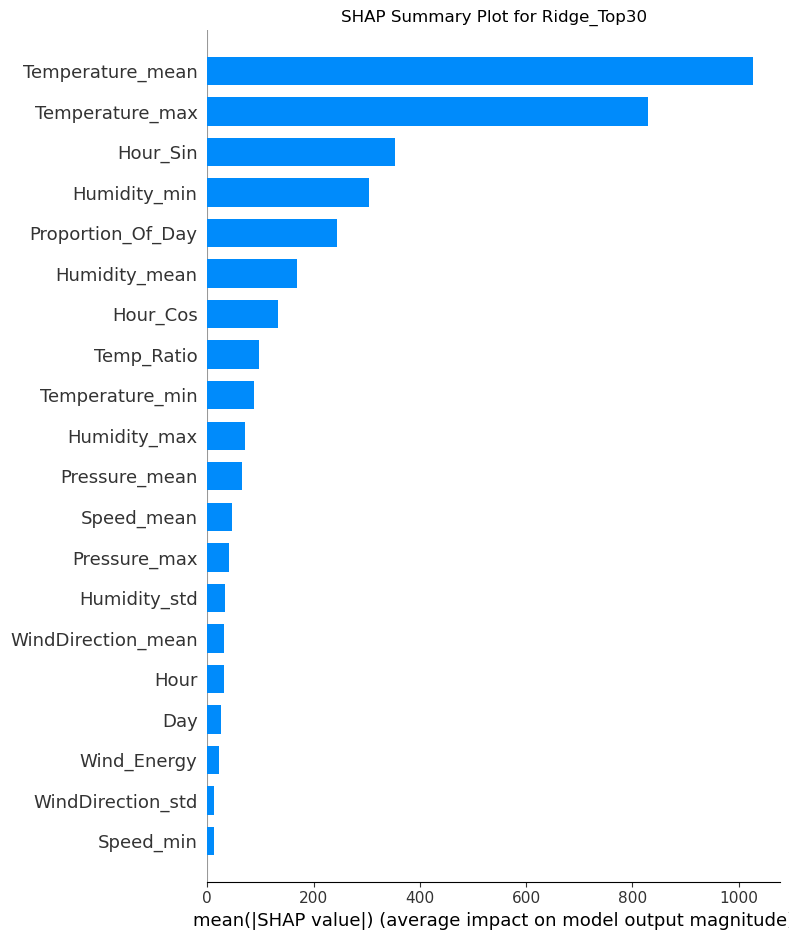

Validation Results for Ridge_Top30: R²: 0.7713, RMSE: 149.8110

Computing SHAP for model: Ridge_Top35


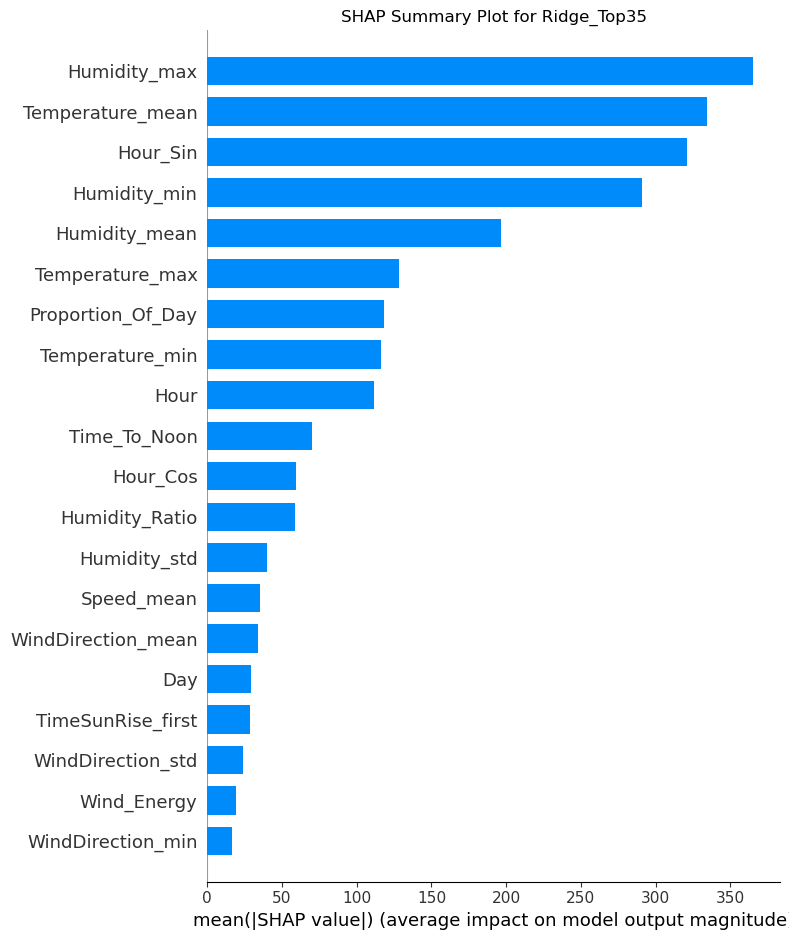

Validation Results for Ridge_Top35: R²: 0.7650, RMSE: 151.8616


In [361]:
# ---------------------------------------------------------------------------------------------------------
# DOCUMENTATION
#
# The following code provides a complete pipeline to train and evaluate various regression models on 
# training, testing, and validation datasets. The models include:
# - Neural networks (with several architectures)
# - XGBRegressor (XGBoost)
# - Lasso
# - Ridge
# - KNN Regressor
#
# It assumes the existence of the following variables:
# - x_train, y_train: training data (features and labels)
# - x_test, y_test: test data (features and labels)
# - x_valid, y_valid: validation data (features and labels)
#
# Functions used:
# 1. build_nn_model(input_dim, architecture):
#    Builds a neural network model with a given architecture. The first element of 'architecture' specifies
#    the number of neurons in the first hidden layer (connected to the input), subsequent elements (except 
#    for the last one) are the hidden layers, and the last element is the output layer (1 neuron for regression).
#    Compiles the model with the Adam optimizer and MSE loss.
#
# 2. train_and_evaluate_nn(x_train, y_train, x_test, y_test, architecture, epochs=50, batch_size=32):
#    Trains a neural network model with the given architecture and returns R² and RMSE on the test set, 
#    along with the trained model.
#
# 3. tune_xgb(x_train, y_train, x_test, y_test):
#    Uses GridSearchCV to find the best hyperparameters for an XGBRegressor. Returns R², RMSE on test set,
#    and the best model.
#
# 4. tune_lasso(x_train, y_train, x_test, y_test):
#    Uses GridSearchCV to fit a Lasso Regression model and returns its performance metrics.
#
# 5. tune_ridge(x_train, y_train, x_test, y_test):
#    Uses GridSearchCV to fit a Ridge Regression model and returns its performance metrics.
#
# 6. tune_knn(x_train, y_train, x_test, y_test):
#    Uses GridSearchCV to fit a KNeighborsRegressor and returns its performance metrics.
#
# 7. run_experiments(x_train, y_train, x_test, y_test, selected_features):
#    Conducts experiments for various subsets of top features ([5,10,15,20,25,30,35,38]) and for each subset:
#    - Trains and evaluates 3 different neural network architectures.
#    - Tunes hyperparameters and evaluates XGB, Lasso, Ridge, and KNN.
#    Returns a dataframe with results for all experiments and another sorted by RMSE.
#
# 8. compute_and_plot_shap_values_for_top_models(results_rmse_sorted, x_train, x_test, x_valid, y_valid):
#    For the top 10 models (by RMSE), computes SHAP values and generates a global SHAP summary plot.
#    Then it evaluates these models on the validation set and prints their R² and RMSE.
#
# At the end, after running run_experiments(...), we get the results and sort them by RMSE.
# Then, compute_and_plot_shap_values_for_top_models(...) analyzes the top models, generates SHAP interpretations, 
# and evaluates their performance on the validation set.
#
# You can copy and run this code in a Jupyter Notebook cell, assuming that x_train, y_train, x_test, y_test, 
# x_valid, y_valid variables and required libraries are defined and installed.
#
# ---------------------------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


def build_nn_model(input_dim, architecture):
    """
    Builds a neural network model for the given architecture.
    architecture - list of neuron counts in hidden layers and output layer.
    """
    model = Sequential()
    # First input layer:
    model.add(Dense(architecture[0], input_dim=input_dim, activation='relu'))
    # Hidden layers
    for units in architecture[1:-1]:
        model.add(Dense(units, activation='relu'))
    # Output layer (regression = 1 neuron)
    model.add(Dense(architecture[-1], activation='linear'))
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model


def train_and_evaluate_nn(x_train, y_train, x_test, y_test, architecture, epochs=50, batch_size=32):
    """
    Trains and evaluates an NN model with the given architecture.
    Returns R² and RMSE on the test set.
    """
    model = build_nn_model(input_dim=x_train.shape[1], architecture=architecture)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, rmse, model


def tune_xgb(x_train, y_train, x_test, y_test):
    """
    Tunes XGBRegressor using GridSearchCV.
    Returns best R², RMSE, and model.
    """
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
    grid = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, rmse, best_model


def tune_lasso(x_train, y_train, x_test, y_test):
    """
    Tunes Lasso Regression using GridSearchCV.
    """
    lasso = Lasso(random_state=42)
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
    }
    grid = GridSearchCV(lasso, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, rmse, best_model


def tune_ridge(x_train, y_train, x_test, y_test):
    """
    Tunes Ridge Regression using GridSearchCV.
    """
    ridge = Ridge(random_state=42)
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
    }
    grid = GridSearchCV(ridge, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, rmse, best_model


def tune_knn(x_train, y_train, x_test, y_test):
    """
    Tunes KNN Regressor using GridSearchCV.
    """
    knn = KNeighborsRegressor()
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return r2, rmse, best_model


def run_experiments(x_train, y_train, x_test, y_test, selected_features):
    """
    Runs all experiments:
    - For top_n features (n in [5,10,15,20,25,30,35,38]):
      * Trains and evaluates 3 different NN architectures.
      * Tunes and evaluates XGB, Lasso, Ridge, and KNN.
    Returns a dataframe of results.
    """
    
    architectures = [
        [64, 32, 16, 8, 4, 2, 1],
        [32, 16, 8, 4, 2, 1],
        [16, 8, 4, 2, 1]
    ]
    
    top_features_list = [5,10,15,20,25,30,35,36]
    
    results = []  # List of dicts with results: {model_name, top_n, R2, RMSE, fitted_model, features}
    
    for top_n in top_features_list:
        # Select top_n features
        chosen_features = selected_features[:top_n]
        X_train_sub = x_train[chosen_features]
        X_test_sub = x_test[chosen_features]
        
        # Neural Networks
        for i, arch in enumerate(architectures, start=1):
            nn_name = f"NeuralNet_Arch{i}_Top{top_n}"
            r2, rmse, fitted_model = train_and_evaluate_nn(X_train_sub.values, y_train.values, X_test_sub.values, y_test.values, arch)
            results.append({
                'Model': nn_name,
                'Top_n_features': top_n,
                'R2': r2,
                'RMSE': rmse,
                'FittedModel': fitted_model,
                'Features': chosen_features
            })
        
        # XGB
        r2, rmse, fitted_model = tune_xgb(X_train_sub, y_train, X_test_sub, y_test)
        results.append({
            'Model': f"XGB_Top{top_n}",
            'Top_n_features': top_n,
            'R2': r2,
            'RMSE': rmse,
            'FittedModel': fitted_model,
            'Features': chosen_features
        })
        
        # Lasso
        r2, rmse, fitted_model = tune_lasso(X_train_sub, y_train, X_test_sub, y_test)
        results.append({
            'Model': f"Lasso_Top{top_n}",
            'Top_n_features': top_n,
            'R2': r2,
            'RMSE': rmse,
            'FittedModel': fitted_model,
            'Features': chosen_features
        })
        
        # Ridge
        r2, rmse, fitted_model = tune_ridge(X_train_sub, y_train, X_test_sub, y_test)
        results.append({
            'Model': f"Ridge_Top{top_n}",
            'Top_n_features': top_n,
            'R2': r2,
            'RMSE': rmse,
            'FittedModel': fitted_model,
            'Features': chosen_features
        })
        
        # KNN
        r2, rmse, fitted_model = tune_knn(X_train_sub, y_train, X_test_sub, y_test)
        results.append({
            'Model': f"KNN_Top{top_n}",
            'Top_n_features': top_n,
            'R2': r2,
            'RMSE': rmse,
            'FittedModel': fitted_model,
            'Features': chosen_features
        })
    
    results_df = pd.DataFrame(results)
    
    # Sort by RMSE (ascending)
    results_rmse_sorted = results_df.sort_values(by='RMSE', ascending=True)
    
    print("=== TOP 10 MODELS BY RMSE ===")
    print(results_rmse_sorted.head(10)[['Model', 'Top_n_features', 'R2', 'RMSE']])
    
    return results_df, results_rmse_sorted


def compute_and_plot_shap_values_for_top_models(results_rmse_sorted, x_train, x_test, x_valid, y_valid):
    """
    For the top 10 models (by RMSE), compute and plot SHAP values globally.
    Additionally, evaluate these top models on the validation set and print the R² and RMSE.
    """
    top_10 = results_rmse_sorted.head(10)
    
    for idx, row in top_10.iterrows():
        model_name = row['Model']
        fitted_model = row['FittedModel']
        features = row['Features']
        
        X_test_sub = x_test[features].copy()
        
        print(f"\nComputing SHAP for model: {model_name}")
        
        # Identify model type to choose the correct explainer
        if "XGB" in model_name:
            explainer = shap.TreeExplainer(fitted_model)
            shap_values = explainer.shap_values(X_test_sub)
        elif "Lasso" in model_name or "Ridge" in model_name:
            explainer = shap.LinearExplainer(fitted_model, X_test_sub)
            shap_values = explainer.shap_values(X_test_sub)
        elif "KNN" in model_name or "NeuralNet" in model_name:
            background = X_test_sub.sample(min(100, len(X_test_sub)), random_state=42)
            explainer = shap.KernelExplainer(fitted_model.predict, background)
            X_test_sample = X_test_sub.sample(min(200, len(X_test_sub)), random_state=42)
            shap_values = explainer.shap_values(X_test_sample)
            X_test_sub = X_test_sample
        else:
            background = X_test_sub.sample(min(100, len(X_test_sub)), random_state=42)
            explainer = shap.KernelExplainer(fitted_model.predict, background)
            X_test_sample = X_test_sub.sample(min(200, len(X_test_sub)), random_state=42)
            shap_values = explainer.shap_values(X_test_sample)
            X_test_sub = X_test_sample
        
        # Plot SHAP summary
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_sub, plot_type='bar', show=False)
        plt.title(f"SHAP Summary Plot for {model_name}")
        plt.tight_layout()
        plt.show()
        
        # Evaluate on validation set
        X_valid_sub = x_valid[features].copy()
        y_valid_pred = fitted_model.predict(X_valid_sub)
        r2_valid = r2_score(y_valid, y_valid_pred)
        mse_valid = mean_squared_error(y_valid, y_valid_pred)
        rmse_valid = np.sqrt(mse_valid)
        
        print(f"Validation Results for {model_name}: R²: {r2_valid:.4f}, RMSE: {rmse_valid:.4f}")


selected_features = x_train.columns.tolist()  # Select all features or another list of features

results_df, results_rmse_sorted = run_experiments(x_train, y_train, x_test, y_test, selected_features)

# Now, we test the top 10 models on the validation set
compute_and_plot_shap_values_for_top_models(results_rmse_sorted, x_train, x_test, x_valid, y_valid)
